In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set a visual style for the plots
sns.set_style("whitegrid")

In [8]:
try:
    df = pd.read_csv('data/data.csv')
except FileNotFoundError:
    print("Error: 'data.csv' not found. Please download it from Kaggle.")
    exit()

print("--- First 5 Rows of the Dataset ---")
print(df.head())

print("--- Dataset Information ---")
df.info()

# --- Data Cleaning and Transformation ---
# The 'TotalCharges' column is sometimes read as an object type because of empty spaces.
# We need to convert it to a numeric type.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# 'coerce' will turn any problematic values into NaN (Not a Number)

# Fill any resulting NaN values (e.g., from customers with zero tenure) with the column median.
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop the customerID column as it's not a useful feature for prediction.
df.drop('customerID', axis=1, inplace=True)

# Convert the target variable 'Churn' into a binary format (0 or 1).
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# --- One-Hot Encoding for Categorical Features ---
# Machine learning models need numerical input, so we convert categorical columns
# into a format they can understand. pd.get_dummies() is perfect for this.
df_encoded = pd.get_dummies(df, drop_first=True)

print("--- Shape of Data After One-Hot Encoding ---")
print(f"The dataset now has {df_encoded.shape[1]} columns.")
print(df_encoded.head())

--- First 5 Rows of the Dataset ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV 

C:\Users\RIYA\AppData\Local\Temp\ipykernel_2976\281658453.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [9]:
# =============================================================================
# # 3. DATA PREPARATION
# =============================================================================
# Define our features (X) and target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [10]:
# =============================================================================
# # 4. TRAINING AND EVALUATING MODELS
# =============================================================================
# --- Model 1: Decision Tree ---
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print("--- Decision Tree Evaluation ---")
print(f"Accuracy: {accuracy_dt:.2f}")
print(classification_report(y_test, y_pred_dt))
print("\n" + "="*50 + "\n")

# --- Model 2: Random Forest ---
# A Random Forest is an ensemble of Decision Trees and is generally more powerful.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("--- Random Forest Evaluation ---")
print(f"Accuracy: {accuracy_rf:.2f}")
print(classification_report(y_test, y_pred_rf))

--- Decision Tree Evaluation ---
Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1552
           1       0.49      0.50      0.50       561

    accuracy                           0.73      2113
   macro avg       0.66      0.66      0.66      2113
weighted avg       0.73      0.73      0.73      2113



--- Random Forest Evaluation ---
Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1552
           1       0.63      0.50      0.56       561

    accuracy                           0.79      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113



--- Top 10 Most Important Features for Predicting Churn ---
                           Feature  Importance
3                     TotalCharges    0.186119
1                           tenure    0.171801
2                   MonthlyCharges    0.167107
10     InternetService_Fiber optic    0.038684
28  PaymentMethod_Electronic check    0.037062
25               Contract_Two year    0.031502
13              OnlineSecurity_Yes    0.029808
4                      gender_Male    0.028664
26            PaperlessBilling_Yes    0.026467
24               Contract_One year    0.023604


C:\Users\RIYA\AppData\Local\Temp\ipykernel_2976\3166458984.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')


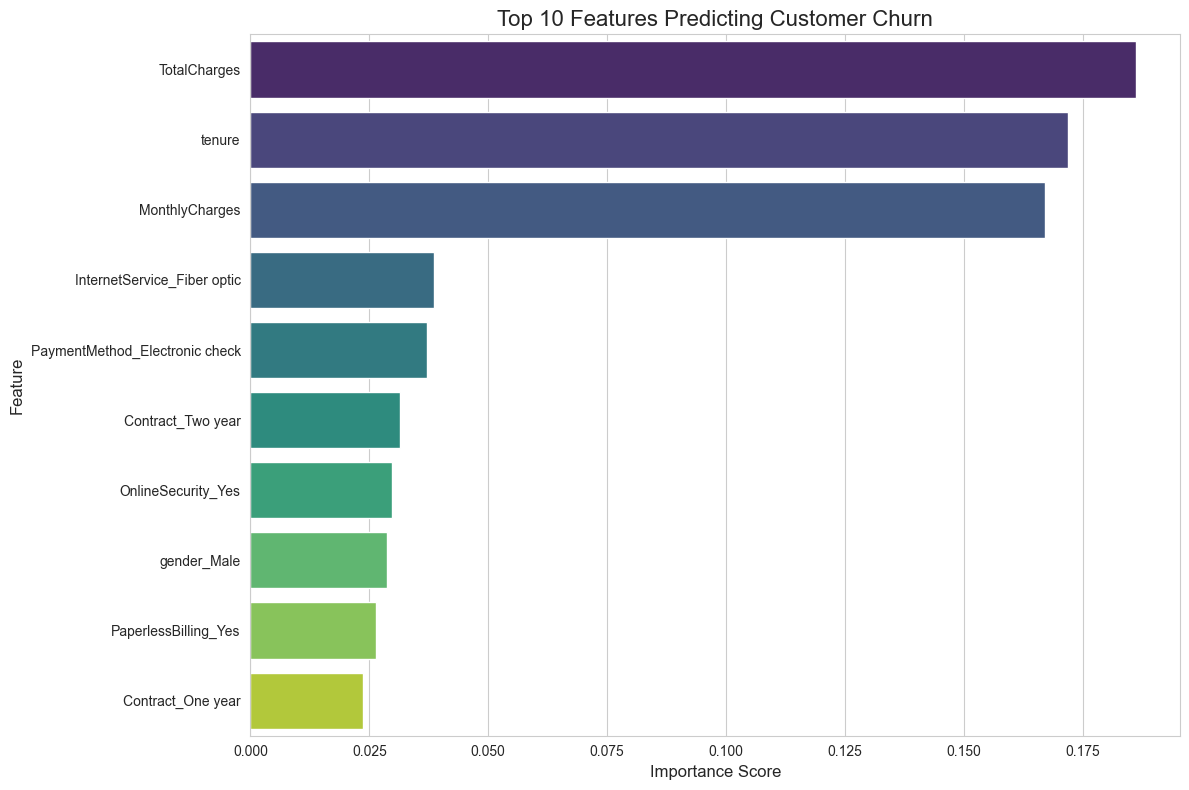

In [11]:
# =============================================================================
# # 5. FEATURE IMPORTANCE FROM RANDOM FOREST
# =============================================================================
# The Random Forest model can tell us which features were most important for predicting churn.
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance and select the top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

print("--- Top 10 Most Important Features for Predicting Churn ---")
print(top_10_features)

# Visualize the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Features Predicting Customer Churn', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance.png') # Save this plot for your LinkedIn post
plt.show()